### This is to retrain using both positive and negative counterfactuals

In [330]:
import xgboost
import joblib
import numpy as np
from sklearn.metrics import accuracy_score
from quadratic_weighted_kappa import quadratic_weighted_kappa
import pandas as pd
import itertools
import math

In [331]:
scores_ori = np.array(joblib.load("files/scores_essay_100_train_ori")).astype(float)
scores_ori.shape

(100,)

In [332]:
scores_ori = np.repeat(scores_ori, 31)

In [333]:
len(scores_ori)

3100

In [334]:
x = joblib.load('files/asap7_features_776').squeeze()
y = joblib.load("files/score_asap7")
y = y.reshape(-1,1)

feature_names = joblib.load('files/feature_names_776')
#model = joblib.load('model_asap1_778')

feats_counter_train_error = joblib.load('files/feats_counter_train_error_776').reshape(-1,776)
new_label_train_error = scores_ori.copy().reshape(3100,-1)

feats_counter_train_better = joblib.load('files/feats_counter_train_correct_776').reshape(-1,776)
new_label_train_better = scores_ori.copy().reshape(3100,-1)

In [335]:
new_label_train_better.shape

(3100, 1)

In [375]:
np.min(y)

2.0

In [377]:
np.std(y)

7.55706323743177

In [337]:
print(scores_ori.dtype)

float64


In [338]:
print(new_label_train_better.dtype)

float64


In [339]:
# =========================
# ADDED: derive min/max and a flat y for indexing
# =========================
y_flat = y.ravel()                                   # ADDED
score_min = float(np.min(y_flat))                    # ADDED
score_max = float(np.max(y_flat))                    # ADDED

#### Apply proposed method: Adjust worse essays label

In [340]:
# There are 100 essay samples with 31 variations

new_label_train_error = new_label_train_error.reshape(100,-1)
new_label_train_error.shape

(100, 31)

In [341]:
n = 5
numbers = range(1, n + 1)  # Numbers from 1 to 5
ctr = 0

for i in range(len(new_label_train_error)):
    # Generate combinations of varying lengths
    idx = 0
    for length in range(1, n + 1):
        combinations = itertools.combinations(numbers, length)
        delta = 3.5 * length  # Adjust delta based on length
        delta = round(delta, 2)
        for combo in combinations:
            new_label_train_error[i][idx] -= delta
            # ADDED: clip this updated label to the valid score range
            new_label_train_error[i][idx] = np.clip(
                new_label_train_error[i][idx], score_min, score_max
            )  # ADDED
            # print("after: ", matrices[i][idx])
            idx += 1

In [342]:
new_label_train_error = new_label_train_error.reshape(-1,1)
new_label_train_error.shape

(3100, 1)

#### Apply proposed method: Adjust better essays label

In [343]:
# There are 100 essay samples with 31 variations

new_label_train_better = new_label_train_better.reshape(100,-1)
new_label_train_better.shape

(100, 31)

In [344]:
n = 5
numbers = range(1, n + 1)  # Numbers from 1 to 5
ctr = 0

for i in range(len(new_label_train_better)):
    # Generate combinations of varying lengths
    idx = 0
    for length in range(1, n + 1):
        combinations = itertools.combinations(numbers, length)
        delta = 3 * length  # Adjust delta based on length
        delta = round(delta, 2)
        for combo in combinations:
            new_label_train_better[i][idx] += delta
            # ADDED: clip this updated label to the valid score range
            new_label_train_better[i][idx] = np.clip(
                new_label_train_better[i][idx], score_min, score_max
            )  # ADDED
            # print("after: ", matrices[i][idx])
            idx += 1

In [345]:
new_label_train_better = new_label_train_better.reshape(-1,1)
new_label_train_better.shape

(3100, 1)

In [346]:
np.array_equal(scores_ori, new_label_train_error.flatten())
np.array_equal(scores_ori, new_label_train_better.flatten())


False

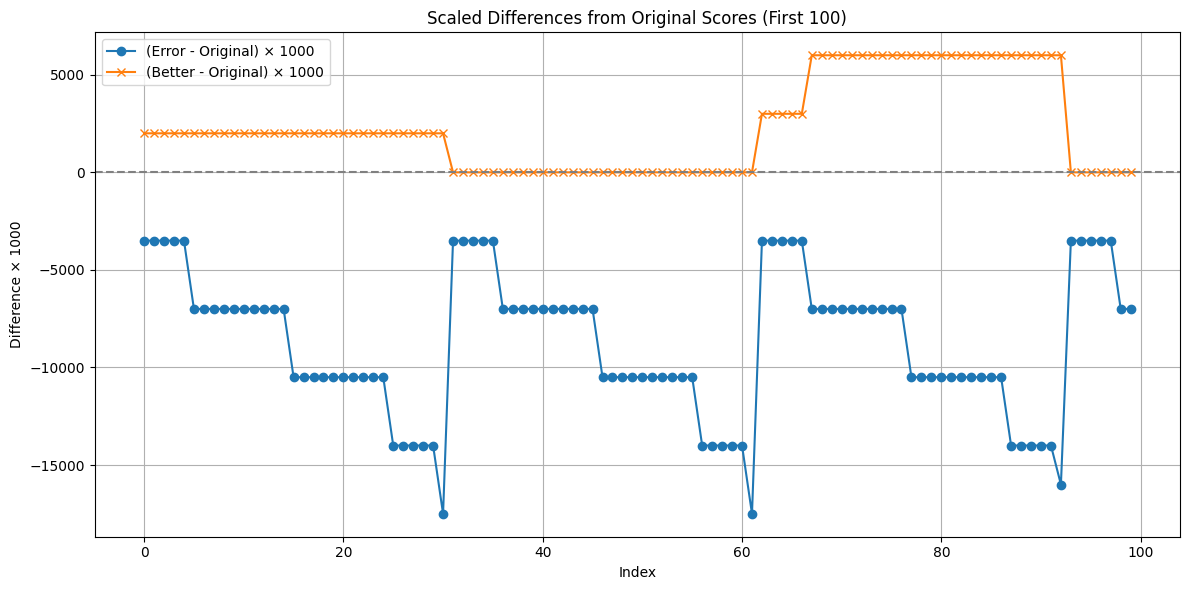

In [347]:
import numpy as np
import matplotlib.pyplot as plt

n_show = 100

# Flatten and slice
ori = scores_ori[:n_show]
err = new_label_train_error[:n_show].flatten()
bet = new_label_train_better[:n_show].flatten()

# Compute and scale differences
diff_err = (err - ori) * 1000
diff_bet = (bet - ori) * 1000

# Plot
plt.figure(figsize=(12, 6))
plt.plot(diff_err, label='(Error - Original) × 1000', marker='o')
plt.plot(diff_bet, label='(Better - Original) × 1000', marker='x')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f'Scaled Differences from Original Scores (First {n_show})')
plt.xlabel('Index')
plt.ylabel('Difference × 1000')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


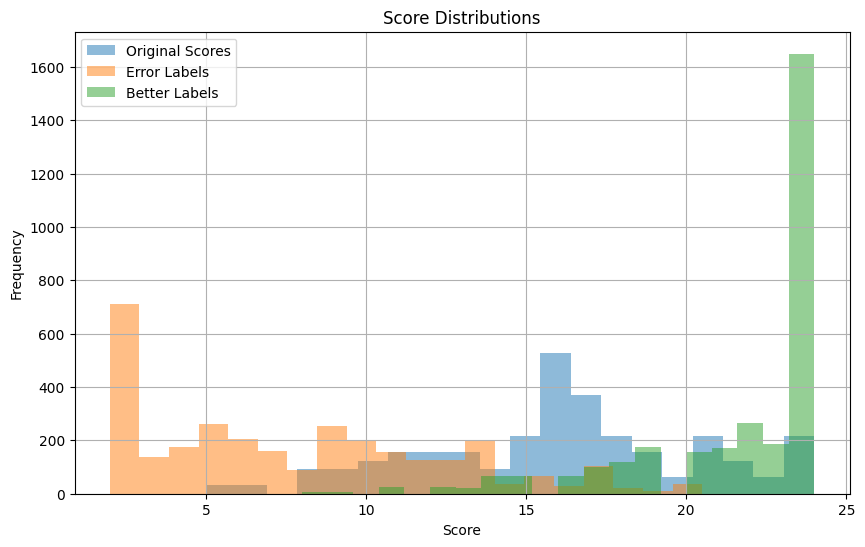

In [348]:
plt.figure(figsize=(10, 6))
plt.hist(scores_ori, bins=20, alpha=0.5, label='Original Scores')
plt.hist(new_label_train_error, bins=20, alpha=0.5, label='Error Labels')
plt.hist(new_label_train_better, bins=20, alpha=0.5, label='Better Labels')
plt.title('Score Distributions')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [349]:
y_counter = np.concatenate((y, new_label_train_better, new_label_train_error), axis=0).reshape(-1)
y_counter.shape

(7769,)

In [350]:
y = y_counter
y.shape

(7769,)

In [351]:
x_counter = np.concatenate((x,feats_counter_train_better, feats_counter_train_error), axis=0)
x_counter.shape

(7769, 776)

In [352]:
x = x_counter
x.shape

(7769, 776)

In [353]:
# REMOVE PROMPT OVERLAP & PROMPT OVERLAP (SYNONYM) FEATURES, AS THEY HAVE NEGATIVE CORRELATION WITH FINAL SCORE

# x_776 = np.delete(x, [5,6],axis=1)
# x_776.shape

In [354]:
# x = x_776
# x.shape

In [355]:
def get_feature_names_extended():
    inter_feats = ['Answer Length', 'Word Count', 'Average Word Length', 'Unique Word Count', 'Punctuation Density',
                  'Prompt Overlap', 'Prompt Overlap (synonyms)', 'Prompt Similarity SBert', 
                  'Spelling Error', 'Language Error']
    inter_feats = ['Answer Length', 'Word Count', 'Average Word Length', 'Unique Word Count', 'Punctuation Density',
                  'Prompt Similarity SBert', 
                  'Spelling Error', 'Language Error']
    
    sbert_feats = []
    sbert_dim = 768

    for i in range(0, sbert_dim):
    	fname = "sbert_" + str(i) 
    	sbert_feats.append(fname)
    
    feature_names = inter_feats + sbert_feats 

    print("len feature names: ", len(feature_names))
    
    return feature_names

feature_names = get_feature_names_extended()#[:12]

len feature names:  776


In [356]:
#joblib.dump(feature_names, 'feature_names_778')

In [357]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [358]:
model = xgboost.XGBRegressor(objective ='reg:squarederror',
                colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.05,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

# ORI QWK : 

In [359]:
# qwk_scores = []

# test_indices = []
# pred_labels = []

# for train_index, test_index in kf.split(x, y):
    
#     X_train, X_test, Y_train, Y_test = x[train_index], x[test_index], y[train_index], y[test_index]
         
#     model.fit(X_train, Y_train)
    
#     predict = model.predict(X_test)
#     predict = np.round(predict)
    
#     pred_labels.extend(predict)
#     test_indices.extend(test_index)
    
#     result = quadratic_weighted_kappa(Y_test, predict)
    
#     print("Qwk : ", result)
#     print(X_train.shape)
#     qwk_scores.append(result)
    
# np.mean(qwk_scores)

##### Only evaluate the original Test Set (without augmentation), but using new Model (trained with augmentation)

In [360]:
qwk_scores = []

for train_index, test_index in kf.split(x, y):
    
    X_train, X_test, Y_train, Y_test = x[train_index], x[test_index], y[train_index], y[test_index]

    # Filter test indices for those less than 1783
    test_index_baru = test_index[test_index < 1783]
    print("Filtered test indices count:", len(test_index_baru))
    
    print(X_train.shape)
    print(Y_train.shape)
    model.fit(X_train, Y_train)

    # Use test_index_baru to get filtered test sets from the original arrays
    X_test_baru = X_test[test_index < 1783]  # Correct filtering
    Y_test_baru = Y_test[test_index < 1783]  # Correct filtering

    print("Filtered X_test count:", len(X_test_baru))
    print("Filtered Y_test count:", len(Y_test_baru))
    
    predict = model.predict(X_test_baru)
    predict = np.round(predict)
    
    result = quadratic_weighted_kappa(Y_test_baru, predict)
    
    print("Qwk : ", result)
    qwk_scores.append(result)

mean_qwk = np.mean(qwk_scores)
print("Mean Qwk:", mean_qwk)


Filtered test indices count: 379
(6215, 776)
(6215,)
Filtered X_test count: 379
Filtered Y_test count: 379
Qwk :  0.7412777444474483
Filtered test indices count: 361
(6215, 776)
(6215,)
Filtered X_test count: 361
Filtered Y_test count: 361
Qwk :  0.764220560462642
Filtered test indices count: 346
(6215, 776)
(6215,)
Filtered X_test count: 346
Filtered Y_test count: 346
Qwk :  0.7690218573762173
Filtered test indices count: 375
(6215, 776)
(6215,)
Filtered X_test count: 375
Filtered Y_test count: 375
Qwk :  0.7831675022374964
Filtered test indices count: 322
(6216, 776)
(6216,)
Filtered X_test count: 322
Filtered Y_test count: 322
Qwk :  0.7504632733078783
Mean Qwk: 0.7616301875663366


In [49]:
print(len(pred_labels))
print(len(test_indices))

7983
7983


In [50]:
new_score = np.zeros(1783)
new_score

array([0., 0., 0., ..., 0., 0., 0.])

In [278]:
#new_score[test_indices] = pred_labels_int

In [173]:
new_score

array([0., 0., 0., ..., 0., 0., 0.])

In [174]:
new_score[60]

0.0

In [175]:
#joblib.dump(new_score, 'score_model_normalized')

## Create model

In [361]:
from sklearn.model_selection import train_test_split
indices = np.arange(len(x))
X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(x, y, indices, test_size=0.2, random_state=42)

In [362]:
len(idx_test)

1554

In [363]:
idx_test

array([1421, 2746, 3473, ...,  904, 1446, 7285])

In [364]:
# Filter the array for values less than 1783
new_array = idx_test[idx_test < 1783]
len(new_array)

379

In [365]:
d_train = xgboost.DMatrix(X_train, label=Y_train, feature_names=feature_names)
d_test = xgboost.DMatrix(X_test, label=Y_test, feature_names=feature_names)

In [366]:
model = xgboost.train({"learning_rate": 0.05, "max_depth":4, 'alpha':0.75, 'lambda':0.45,}, d_train, 400, evals = [(d_test, "test")], early_stopping_rounds=50)

[0]	test-rmse:15.72457
[1]	test-rmse:15.05755
[2]	test-rmse:14.42863
[3]	test-rmse:13.83549
[4]	test-rmse:13.27759
[5]	test-rmse:12.75019
[6]	test-rmse:12.25308
[7]	test-rmse:11.79167
[8]	test-rmse:11.35438
[9]	test-rmse:10.95265
[10]	test-rmse:10.56061
[11]	test-rmse:10.19896
[12]	test-rmse:9.86311
[13]	test-rmse:9.54198
[14]	test-rmse:9.24406
[15]	test-rmse:8.96889
[16]	test-rmse:8.70669
[17]	test-rmse:8.46246
[18]	test-rmse:8.22850
[19]	test-rmse:8.01248
[20]	test-rmse:7.81435
[21]	test-rmse:7.63201
[22]	test-rmse:7.46091
[23]	test-rmse:7.28761
[24]	test-rmse:7.13008
[25]	test-rmse:6.98760
[26]	test-rmse:6.85148
[27]	test-rmse:6.72072
[28]	test-rmse:6.60036
[29]	test-rmse:6.49471
[30]	test-rmse:6.39184
[31]	test-rmse:6.30115
[32]	test-rmse:6.21440
[33]	test-rmse:6.13119
[34]	test-rmse:6.05734
[35]	test-rmse:5.98603
[36]	test-rmse:5.91330
[37]	test-rmse:5.84687
[38]	test-rmse:5.78429
[39]	test-rmse:5.72257
[40]	test-rmse:5.66613
[41]	test-rmse:5.62030
[42]	test-rmse:5.57414
[43]	test

In [367]:
yxgb_pred = model.predict(d_test)
yxgb_pred = np.round(yxgb_pred)

In [371]:
accuracy_score(yxgb_pred, np.round(Y_test))

0.09523809523809523

In [372]:
quadratic_weighted_kappa(yxgb_pred, Y_test)

0.8693496167988403

In [373]:
joblib.dump(model, 'files/model_asap7_776_counter_both_ori_adjusted_clip')

['files/model_asap7_776_counter_both_ori_adjusted_clip']

## Model interpretation

In [67]:
imp_vals = model.get_fscore()
#print(imp_vals)
feature_important = model.get_score(importance_type='weight')
feats_sorted = sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
aa_25 = feats_sorted[:25]

In [68]:
x_axis = [i[0] for i in aa_25]
y_axis = [i[1] for i in aa_25]

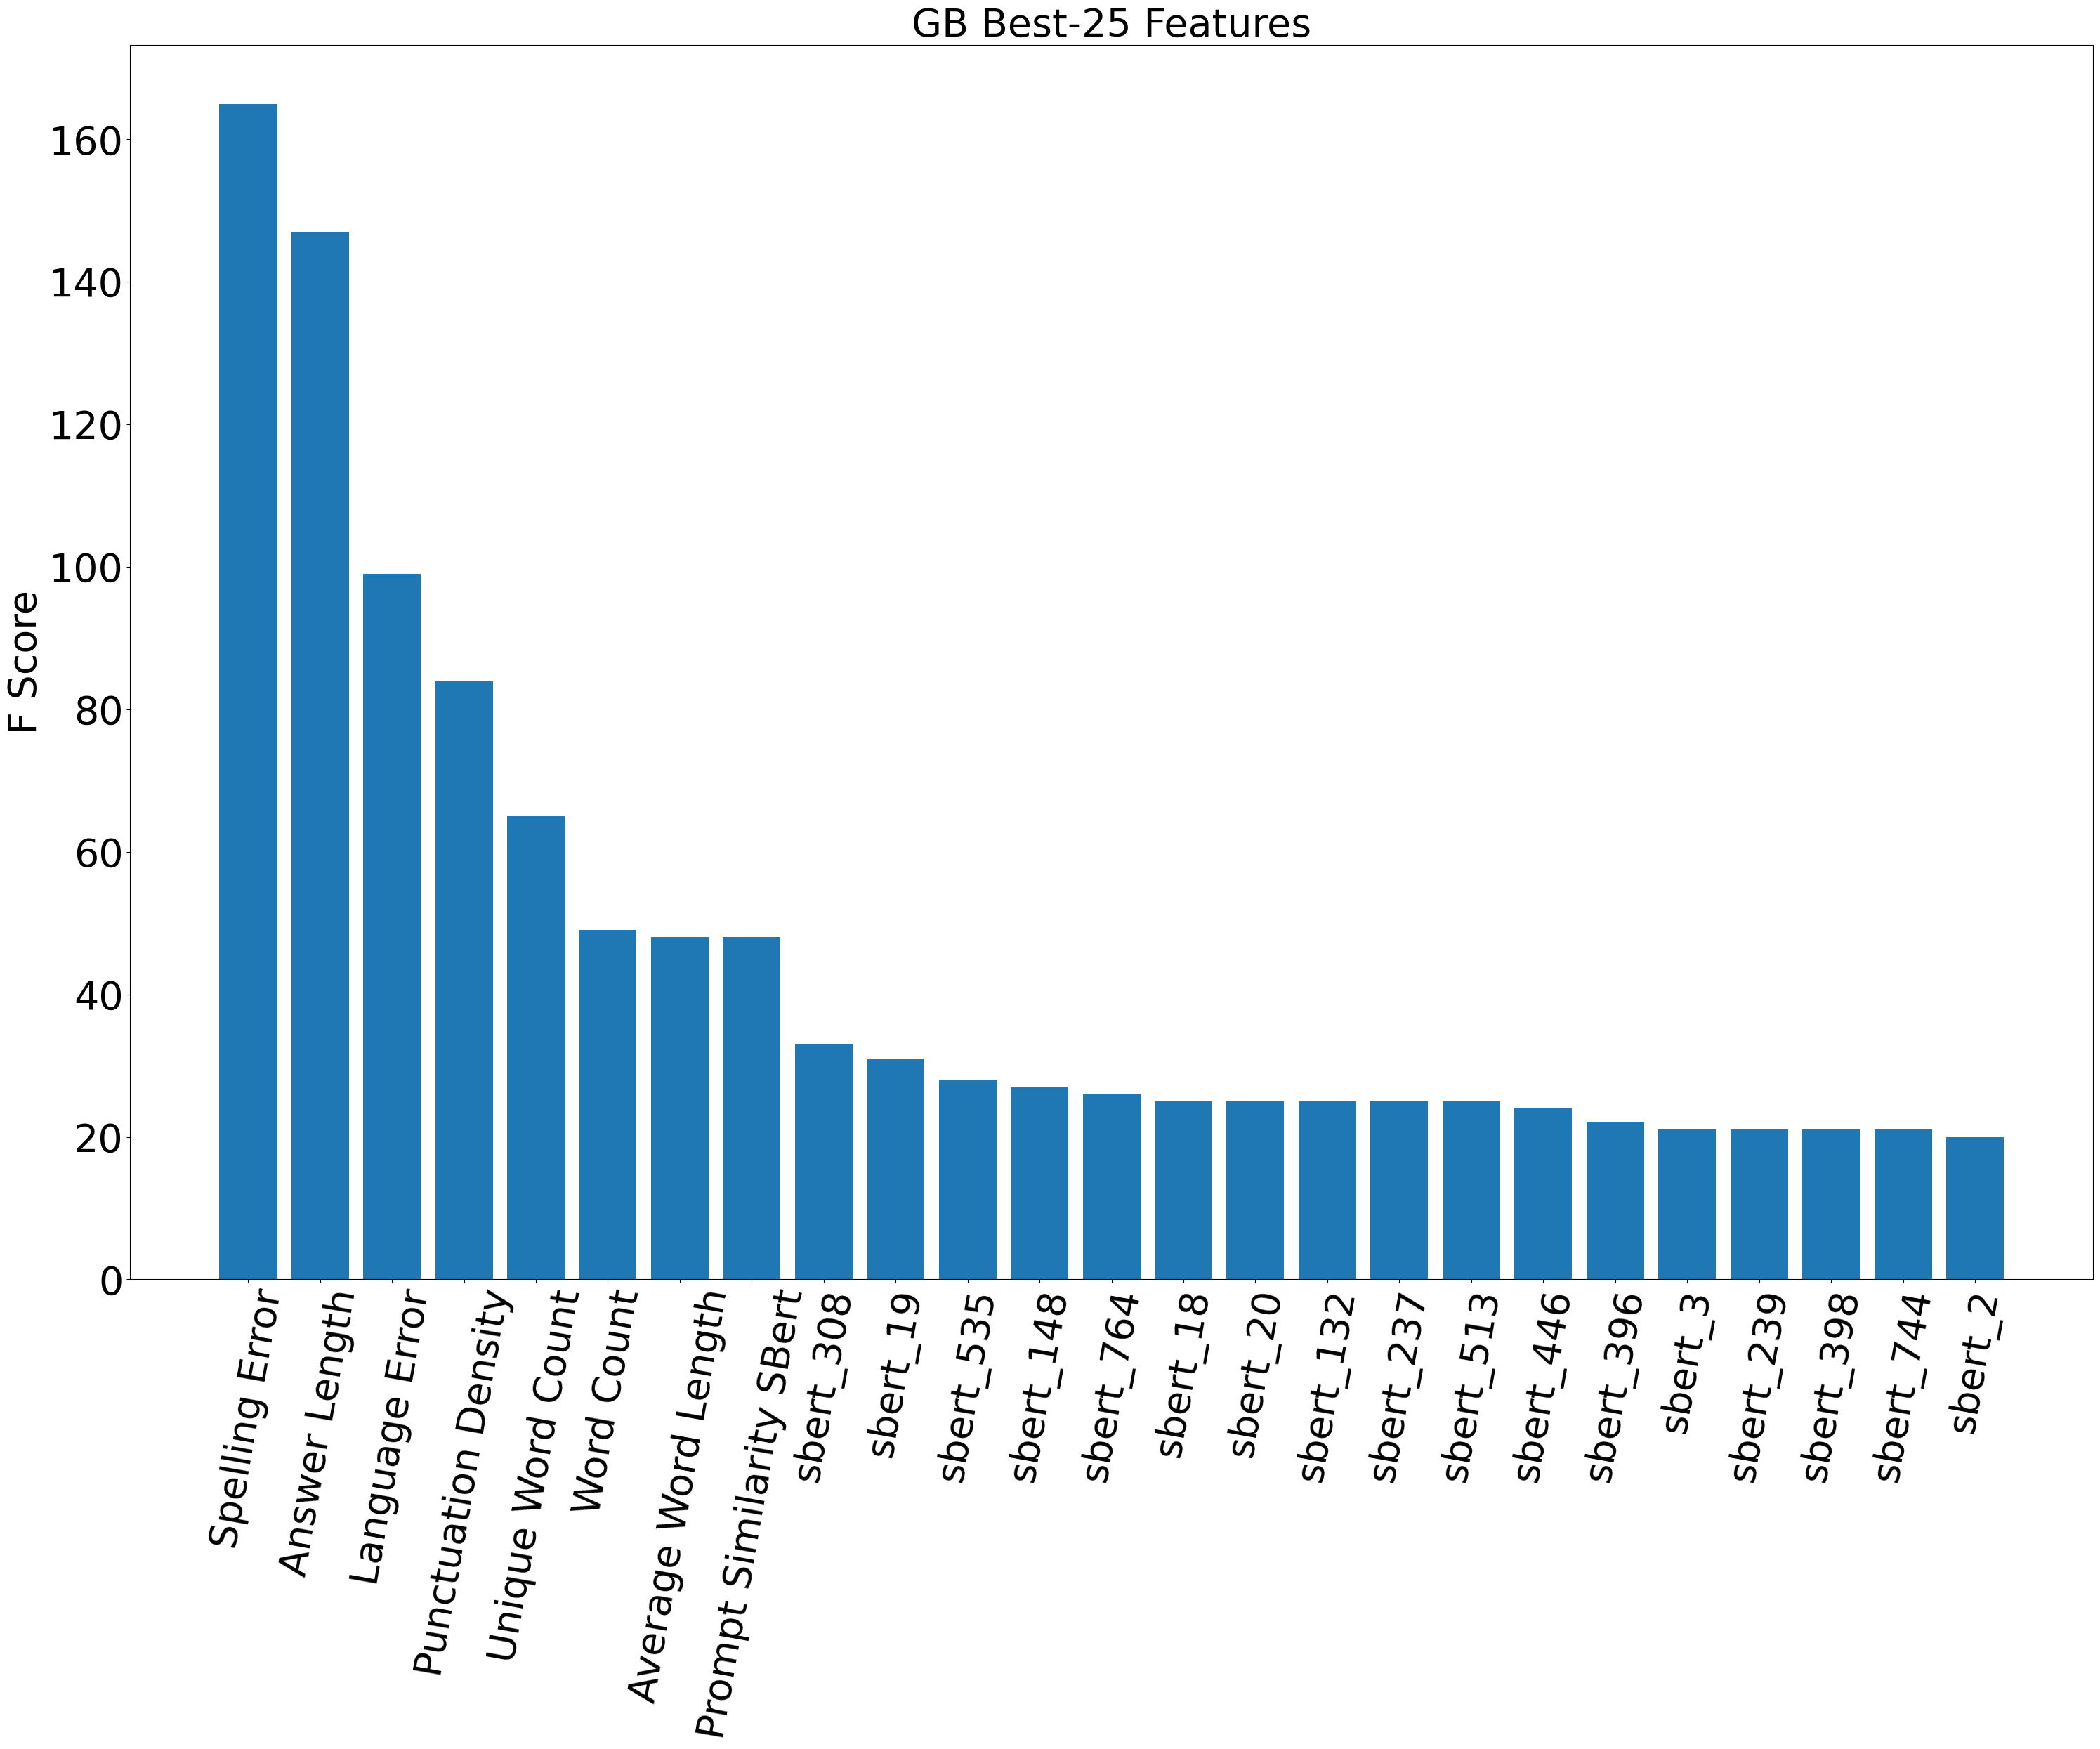

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,25))
plt.title("GB Best-25 Features", fontsize=40)
plt.bar(x_axis, y_axis, width=0.8, align='center')
plt.xticks(x_axis, fontsize=40, rotation=80)
plt.ylabel("F Score", fontsize=40)
plt.yticks(fontsize=40)
plt.tight_layout()
plt.savefig('gb_best_25.png')
plt.show()

### Get Testing Data

In [1]:
import joblib

In [3]:
asap1 = joblib.load('files/asap1_essay')

In [4]:
len(asap1)

1783

In [5]:
asap1

,essay_id,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8
1,2,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...
1778,1783,"Dear @CAPS1, @CAPS2 several reasons on way I t...",8
1779,1784,Do a adults and kids spend to much time on the...,7
1780,1785,My opinion is that people should have computer...,8
1781,1786,"Dear readers, I think that its good and bad to...",2


In [64]:
type(asap1)

pandas.core.frame.DataFrame

In [65]:
asap1_test = asap1.iloc[idx_test]

In [66]:
len(asap1_test)

357

In [67]:
#asap1_test

In [68]:
asap1_test.to_csv('ASAP1 Test Set.tsv', index=False, sep='\t')

In [69]:
df = pd.read_csv('ASAP1 Test Set.tsv', sep='\t', encoding = "ISO-8859-1")

### Get Training Data

In [70]:
asap1_train = asap1.iloc[idx_train]

In [71]:
len(asap1_train)

1426

In [72]:
asap1_train.to_csv('ASAP1 Train Set.tsv', index=False, sep='\t')

In [73]:
df = pd.read_csv('ASAP1 Train Set.tsv', sep='\t', encoding = "ISO-8859-1")

In [1]:
import itertools 

n = 4 # OPEN AI GIVES A LOT OF SUGGESTIONS
numbers = range(1, n + 1) 

ctr = 0
for length in range(1, n + 1):
    print("Combination with length: ", length)
    combinations = itertools.combinations(numbers, length)
    delta = 0.4 * length  # Adjust delta based on length
    delta = round(delta, 2)
    for combo in combinations:
        print(combo)
        ctr += 1

print("Total number: ", ctr)

Combination with length:  1
(1,)
(2,)
(3,)
(4,)
Combination with length:  2
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
Combination with length:  3
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
Combination with length:  4
(1, 2, 3, 4)
Total number:  15


In [ ]:
FROM 1 ESSAY --> we generate 31 new better essays --> Why 31 --> 2^n - 1 --> 2 ^ 5 -1 = 31

In [ ]:
I TOOK 100 ESSAYS RANDOMLY --> 3100 NEW BETTER ESSAYS --> WE NEED NEW LABELS FOR THOSE 3100 DATA

In [ ]:
THEN, WE DO THE SAME FROM EXACTLY THE SAME 100 ESSAYS --> BUT NOW WORSE ESSAYS --> 3100 NEW ESSAYS

In [ ]:
SO, IN THE END WE HAVE 6200 AUGMENTATION DATA
THE ORIGINAL ESSAYS ARE ONLY 1700 DATA

In [ ]:
n = 5
numbers = range(1, n + 1)  # Numbers from 1 to 5
ctr = 0

for i in range(len(new_label_train_error)):
    # Generate combinations of varying lengths
    idx = 0
    for length in range(1, n + 1):
        combinations = itertools.combinations(numbers, length)
        delta = 0.3 * length  # Adjust delta based on length
        delta = round(delta, 2)
        for combo in combinations:
            new_label_train_error[i][idx] -= delta
            print(combo)
            idx += 1

In [14]:
import itertools
n = 4
numbers = range(1, n + 1)
ctr = 0

for length in range(1, n + 1):
    combinations = itertools.combinations(numbers, length)
    print("length: ", length)
    for combo in combinations:
        print(combo)
        ctr += 1
print("Total : ", ctr)

length:  1
(1,)
(2,)
(3,)
(4,)
length:  2
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)
length:  3
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)
length:  4
(1, 2, 3, 4)
Total :  15


In [23]:
import itertools
n = 5
numbers = range(1, n + 1)
ctr = 0

for length in range(1, n + 1):
    combinations = math.comb(len(numbers), length)
    print("length: ", length)
    for j in range(combinations):
        print(length)
        ctr += 1
print("Total : ", ctr)

length:  1
1
1
1
1
1
length:  2
2
2
2
2
2
2
2
2
2
2
length:  3
3
3
3
3
3
3
3
3
3
3
length:  4
4
4
4
4
4
length:  5
5
Total :  31


In [58]:
import math

def binomial(n, k):
    return math.comb(n, k)

def cumulative_sums(n):
    S = [0]  # S(0) = 0
    for k in range(1, n + 1):
        S.append(S[k - 1] + binomial(n, k))  # Cumulative sum
    return S

def generate_k_array(n):
    S = cumulative_sums(n)  # Get cumulative sums
    print(S)
    result = []
    
    for i in range(S[-1]):  # Iterate up to the total number of combinations
        for k in range(1, n + 1):
            if S[k - 1] <= i < S[k]:
                result.append(k)  # Append the current k
                break  # Move to the next index

    return result

# Example usage
n = 4
k_array = generate_k_array(n)
print(k_array)


0
4
10
14
[0, 4, 10, 14, 15]
[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4]


In [31]:
binomial(4,2)

6

In [42]:
cumulative_sums(4)

S[k-1] :  0
n :  4 k :  1
S[k-1] :  4
n :  4 k :  2
S[k-1] :  10
n :  4 k :  3
S[k-1] :  14
n :  4 k :  4


[0, 4, 10, 14, 15]